In [69]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import groupby
from operator import itemgetter
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, classification_report, accuracy_score
from scipy.stats import kruskal, f_oneway
from scikit_posthocs import posthoc_dunn
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import re
import cv2

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, scale
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors, metrics)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_selection import (f_classif, VarianceThreshold, chi2, mutual_info_classif, SelectKBest,
                                       SelectPercentile)
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression, Lasso 

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from scipy.cluster.hierarchy import dendrogram
from scipy import stats
from scipy.stats import linregress

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [70]:
analysisFolder = '/Users/sbk/Documents/IVRS/Ruta/';
picFolder = '/Users/sbk/Library/CloudStorage/Box-Box/GBM/Paper/Figs'

df2 = pd.read_excel(analysisFolder + 'MergedData.xlsx')
df2.NCells[df2.NCells == 'Low'] = 'LN';
df2.NCells[df2.NCells == 'High'] = 'HN';
df2.NCells = df2.NCells.astype('category');
df2.Mouse = df2.Mouse.astype('category');
df2 = df2[(df2.Week <= 12)];
#df2.Week = df2.Week.astype('category');
df2.Size[df2.Size == 'No Tumor'] = 'NT';
df2.Size[df2.Size == 'Medium'] = 'MS';
df2.Size[df2.Size == 'Large'] = 'LS';
#df2.NormFlux[df2.NormFlux < 0] = 0;
df2.NormFlux = df2.NormFlux+1;
df2['logRadiance'] = np.log10(df2.NormFlux)
#df2.MT[df2.MT >= 59] = None;



In [71]:
#Remove outliers and NaNs:
df2.drop([11, 23, 44, 59, 83, 87, 103], inplace = True)
df2.dropna(subset = 'MT', inplace = True)
df2.reset_index(inplace = True, drop = True)
df2.head()

,Unnamed: 0,Mouse,Week,Date_x,NCells,DistTrav,AvgSpeed,OccCenter,OccPeri,OccRatio,...,Weight,TotalFlux,Avg-BKG Flux,Comments,MTScore,MT,NormFlux,Size,SizeScore,logRadiance
0,0,5,4,2023-02-24,Sham,180921.818774,80.722306,405,1836,0.220588,...,23.6,18780,3288.0,NaN,3,37.666667,1.0,NT,0,0.000000
1,1,4,3,2023-02-17,LN,579095.402063,107.228386,42,5334,0.007874,...,23.2,166900,13998.2,NaN,3,43.425000,13466.9,MS,1,4.129268
2,2,8,3,2023-03-07,Sham,668739.622980,123.824914,1408,3908,0.360287,...,23.5,23850,1282.0,NaN,3,43.870000,1.0,NT,0,0.000000
3,3,9,8,2023-04-11,HN,527555.148690,97.684295,0,5328,0.000000,...,24.5,930000,80746.6,NaN,3,31.906667,79797.6,MS,1,4.901990
4,4,3,5,2023-03-03,Sham,748972.592728,138.710415,458,4806,0.095298,...,22.2,16390,757.0,NaN,3,34.096667,1.0,NT,0,0.000000


In [72]:
#check for outliers in the tumor volume:
def getOutliers(data, col):
    # Calculate the interquartile range (IQR)
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1

    # Define a threshold for detecting outliers
    threshold = 1.5

    # Identify outliers
    outliers = data[(data[col] < (q1 - threshold * iqr)) | (data[col] > (q3 + threshold * iqr))]

    # Print the outliers
    #print(outliers)
    return outliers

In [73]:
sizeLabels = ['NT', 'MS', 'LS'];
nLabels = ['Sham', 'LN', 'HN'];
#df2['Size'] = np.repeat('No Tumor',len(df2));
#df2.Size[(df2.NormFlux >= 10) & (df2.NormFlux < 100000)] = 'Medium';
#df2.Size[(df2.NormFlux >= 100000)] = 'Large';


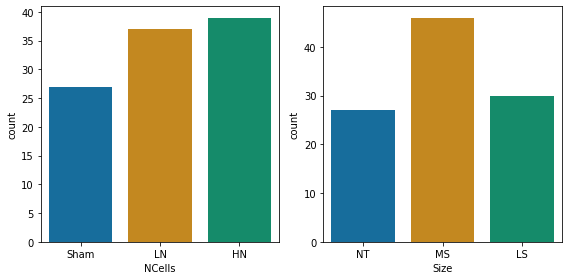

In [74]:
fig, ax = plt.subplots(1,2, figsize = (8,4));
sns.countplot(data= df2, x = 'NCells', ax = ax[0], order = ['Sham', 'LN', 'HN'], palette = 'colorblind');
sns.countplot(data= df2, x = 'Size', ax = ax[1], order = sizeLabels, palette = 'colorblind');
plt.tight_layout()

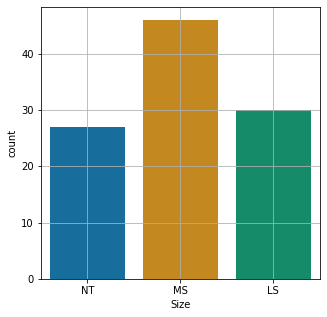

In [75]:
fig, ax = plt.subplots(1,1, figsize = (5,5));
sns.countplot(data= df2, x = 'Size', ax = ax, order = sizeLabels, palette = 'colorblind');
#ax.set_xscale('log')
ax.grid()
plt.show()

In [76]:
cbpal = sns.color_palette('colorblind', 3)
cbpal

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)]

In [77]:
def getPalette(df, labels):
    sns.set_color_codes()
    if labels == 'NCells':
        pal = {NCells: 'b' if NCells == 'LN' else ('gray' if NCells == 'HN' else 'k') for NCells in df['NCells'].unique()}
    elif labels == 'Size':
        pal = {Size: cbpal[1] if Size == 'MS' else (cbpal[2] if Size == 'LS' else cbpal[0]) for Size in df['Size'].unique()}
        
    return pal

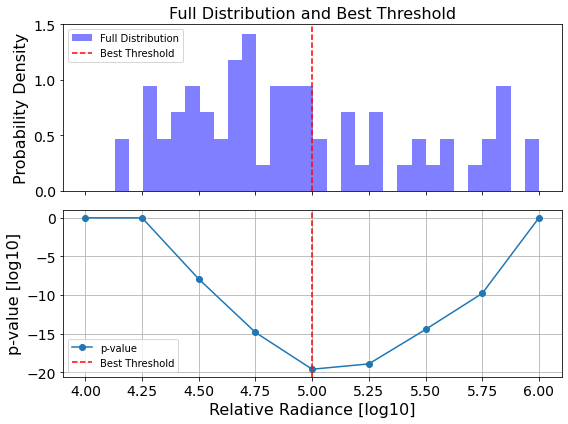

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Generate a sample dataset (replace with your own data)
bmin = 4
bmax = 6
step = 0.25
data = df2[(df2.logRadiance>=bmin) & (df2.logRadiance <= bmax)]['logRadiance']

# Define a range of threshold values
#threshold_values = np.linspace(np.min(data), np.max(data), num=1000)
threshold_values = np.arange(bmin, bmax+step, step)

# Initialize arrays to store p-values and means of the sub-distributions
p_values = []
means_subdist1 = []
means_subdist2 = []

# Perform threshold search analysis
for threshold in threshold_values:
    subdist1 = data[data <= threshold]
    subdist2 = data[data > threshold]
    
    if len(subdist1) > 5 and len(subdist2) > 5:  # Ensure sub-distributions have a minimum number of data points
        _, p_value = stats.ttest_ind(subdist1, subdist2)
        p_values.append(p_value)
        means_subdist1.append(np.mean(subdist1))
        means_subdist2.append(np.mean(subdist2))
    else:
        p_values.append(1.0)  # Assign a high p-value if sub-distributions are too small for the t-test

# Find the threshold value with the lowest p-value
best_threshold = threshold_values[np.argmin(p_values)]

# Plot the results
fig, ax = plt.subplots(2,1,figsize=(8, 6), sharex =  True)
hax = ax[0]
hax.hist(data, bins=30, alpha=0.5, color='blue', label='Full Distribution', density=True)
hax.axvline(x=best_threshold, color='red', linestyle='--', label='Best Threshold')
hax.legend(loc = 'upper left')
hax.set_title('Full Distribution and Best Threshold', fontsize=16)
hax.set_ylabel('Probability Density', fontsize=16)
hax.set_ylim([0, 1.5])
hax.tick_params(axis='both', labelsize=14)

hax = ax[1]
hax.plot(threshold_values, np.log10(p_values), label='p-value', marker = 'o')
hax.axvline(x=best_threshold, color='red', linestyle='--', label='Best Threshold')
hax.set_xlabel('Relative Radiance [log10]', fontsize=16)
hax.set_ylabel('p-value [log10]', fontsize=16)
hax.tick_params(axis='both', labelsize=14)
hax.legend()
hax.grid()

fname = picFolder + '/BestThreshold.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.show()


LN sample does not appear to be normally distributed (reject null hypothesis)
HN sample does not appear to be normally distributed (reject null hypothesis)

Mann-Whitney U statistics: 385.0
P-value: 0.0004797482968778192

LN week 3 vs HN week 3 pval = 0.0023151138829677065
LN week 10 vs HN week 10 pval = 0.13038073038073036
LN week 3 vs LN week 10 pval = 0.00010584530708369718
HN week 3 vs HN week 10 pval = 0.0010637453361911566
LN week 10 vs HN week 3 pval = 0.02524410573946178
LN week 3 vs HN week 10 pval = 2.6461326770924294e-05


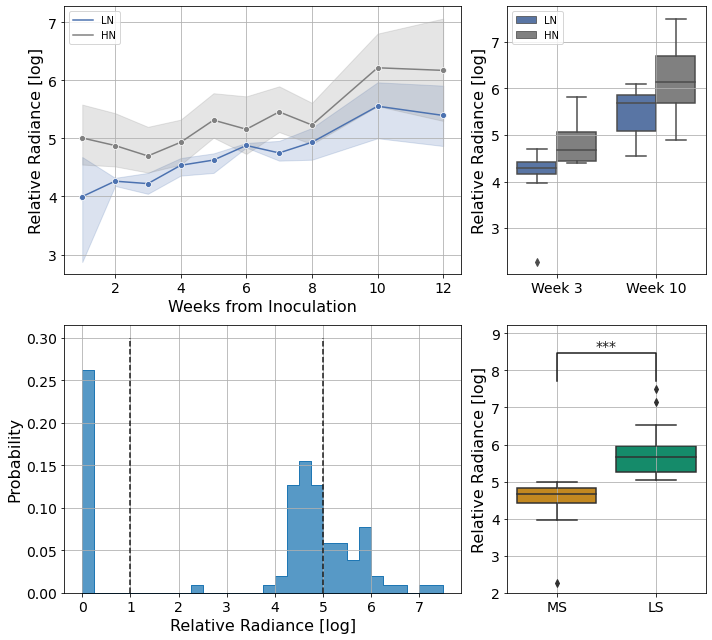

In [79]:
fig, ax = plt.subplots(2,2, figsize = (10,9), gridspec_kw={'width_ratios': [2, 1]});
h_ax = ax[0,0]
sns.set_color_codes()
bdata= df2[df2.NCells != 'Sham']
bdata.reset_index(drop = True, inplace = True)
g = sns.lineplot(data= bdata, x = 'Week', y = 'logRadiance',
                  ax = h_ax, hue = 'NCells', hue_order=['LN', 'HN'], palette = getPalette(bdata, 'NCells'), 
                  marker = 'o');
#ax.set_yscale('log')
h_ax.set_xlabel('Weeks from Inoculation', fontsize = 16)
h_ax.set_ylabel('Relative Radiance [log]', fontsize = 16)
h_ax.tick_params(axis='both', labelsize=14)
h_ax.grid()
legend = g.legend(loc='upper left')
legend.set_title(None)

# Perform the Shapiro-Wilk test to test for normality:
for bset in ['LN', 'HN']:
    stat, p = stats.shapiro(df2[(df2.NCells == bset)]['logRadiance'])
    # Check for normality (use a significance level, e.g., alpha = 0.05)
    alpha = 0.05
    if p > alpha:
        print(f'{bset} sample appears to be normally distributed (fail to reject null hypothesis)')
    else:
        print(f'{bset} sample does not appear to be normally distributed (reject null hypothesis)')

#Statistics for 'LN' and 'HN' groups
data_ln = df2[(df2.NCells == 'LN')]['logRadiance']
data_hn = df2[(df2.NCells == 'HN')]['logRadiance']
statistic, p_value = stats.mannwhitneyu(data_ln, data_hn, alternative='two-sided')
# Output results
print(f"\nMann-Whitney U statistics: {statistic}")
print(f"P-value: {p_value}\n")
    
#comparison 1st vs 12th week:
WK1 = 3
WK2 = 10    
dummy = df2[(df2.Week <= WK1) | (df2.Week >= WK2)];
dummy['WeekL'] = np.repeat('Week 1', len(dummy));
dummy.WeekL[dummy.Week <= WK1] = f'Week {WK1}';
dummy.WeekL[dummy.Week >= WK2] = f'Week {WK2}';
dummy = dummy[dummy.NCells != 'Sham'];
dummy.reset_index(drop = True, inplace=True)


var = 'logRadiance';
h_ax = ax[0,1]
g = sns.boxplot(data=dummy, x = 'WeekL', y=var, ax=h_ax, hue='NCells', hue_order = ['LN', 'HN'], order=[f'Week {WK1}', f'Week {WK2}'], palette = getPalette(dummy, 'NCells'))
h_ax.set_xticks([0,1])
h_ax.set_xticklabels([f'Week {WK1}', f'Week {WK2}'])
h_ax.set_xlabel(None)
h_ax.set_ylabel('Relative Radiance [log]', fontsize=16)
h_ax.tick_params(axis='both', labelsize=14)
h_ax.grid()
g.legend_.set_title(None)

# Perform the Mann-Whitney U test
set1 = dummy[(dummy.NCells == 'LN') & (dummy.Week <= WK1)][var]
set2 = dummy[(dummy.NCells == 'HN') & (dummy.Week <= WK1)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'LN week {WK1} vs HN week {WK1} pval = {p_value}');

# Perform the Mann-Whitney U test
set1 = dummy[(dummy.NCells == 'LN') & (dummy.Week >= WK2)][var]
set2 = dummy[(dummy.NCells == 'HN') & (dummy.Week >= WK2)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'LN week {WK2} vs HN week {WK2} pval = {p_value}');

set1 = dummy[(dummy.NCells == 'LN') & (dummy.Week <= WK1)][var]
set2 = dummy[(dummy.NCells == 'LN') & (dummy.Week >= WK2)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'LN week {WK1} vs LN week {WK2} pval = {p_value}');

set1 = dummy[(dummy.NCells == 'HN') & (dummy.Week <= WK1)][var]
set2 = dummy[(dummy.NCells == 'HN') & (dummy.Week >= WK2)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'HN week {WK1} vs HN week {WK2} pval = {p_value}');  

set1 = dummy[(dummy.NCells == 'LN') & (dummy.Week >= WK2)][var]
set2 = dummy[(dummy.NCells == 'HN') & (dummy.Week <= WK1)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'LN week {WK2} vs HN week {WK1} pval = {p_value}');

set1 = dummy[(dummy.NCells == 'LN') & (dummy.Week <= WK1)][var]
set2 = dummy[(dummy.NCells == 'HN') & (dummy.Week >= WK2)][var]
statistic, p_value = stats.mannwhitneyu(set1, set2)
print(f'LN week {WK1} vs HN week {WK2} pval = {p_value}');    

#Histogram of Radiance:
h_ax = ax[1,0]
sns.histplot(data= df2, x = 'logRadiance', bins = 30, stat = 'probability', log_scale = False, kde =  False, ax = h_ax, element = 'step', palette = 'b');
h_ax.vlines(x = 1, ymin = 0, ymax = 0.3, color = 'k', linestyle='--')
h_ax.vlines(x = 5, ymin = 0, ymax = 0.3, color = 'k', linestyle='--')
h_ax.tick_params(axis='both', labelsize=14)
h_ax.set_ylabel('Probability', fontsize = 16)
h_ax.set_xlabel('Relative Radiance [log]', fontsize = 16)
h_ax.grid()

#comparison medium and large size tumors:
# Perform the Mann-Whitney U test
var = 'logRadiance';
medium_size = df2[df2.Size == 'MS'][var]
large_size = df2[df2.Size == 'LS'][var]
statistic, p_value = stats.mannwhitneyu(medium_size, large_size)

# Annotate the plot with the significance level
if p_value < 0.05:  # Assuming a significance level of 0.05
    significance = "*"
    if p_value <= 0.001:
        significance = "**";
    if p_value <= 0.0001:
        significance = "***" 
else:
    significance = "ns"  # Not significant

h_ax = ax[1,1]
dummy = df2[df2.Size != 'NT'];
dummy.reset_index(drop = True, inplace=True)

var = 'logRadiance';
sns.boxplot(data=dummy, x='Size', y=var, ax=h_ax, order=['MS', 'LS'], palette = getPalette(dummy, 'Size'))
#ax.set_yscale('log')
h_ax.set_xlabel(None)
h_ax.set_ylabel('Relative Radiance [log]', fontsize=16)
h_ax.grid()
g.legend_.set_title(None)

# Annotate the plot with the significance level
x1, x2 = 0, 1  # Positions of the boxplot groups
y =  dummy[var].max() * 1.03;
h, col = dummy[var].max() * 0.1, 'k'  # Position and style of the significance annotation
h_ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
h_ax.text((x1 + x2) * .5, y + h, significance, ha='center', va='bottom', color=col, fontsize=14)
h_ax.set_ylim([2, y + 2*h])
h_ax.tick_params(axis='both', labelsize=14)

fname = picFolder + '/TumorGrowth.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.show()

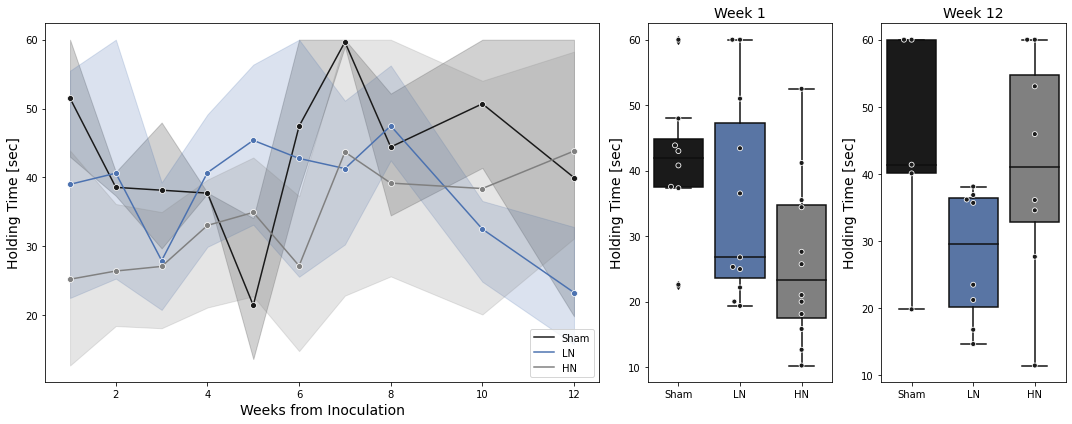

In [80]:
fig, ax = plt.subplots(1,3, figsize = (15,6), gridspec_kw={'width_ratios': [3, 1, 1]});

g = sns.lineplot(data= df2, x = 'Week', y = 'MT', ax = ax[0], hue = 'NCells', hue_order=nLabels, palette = getPalette(df2, 'NCells'),  marker = 'o');
ax[0].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[0].set_xlabel('Weeks from Inoculation', fontsize = 14)
g.legend_.set_title(None)
ax[0].legend(loc='lower right')

sns.boxplot(data= df2[(df2.Week <= 3)],  y = 'MT', ax = ax[1], x = 'NCells', order=nLabels, palette = getPalette(df2, 'NCells'));
sns.swarmplot(data= df2[(df2.Week <= 3)],  y = 'MT', ax = ax[1], x = 'NCells', order=nLabels, color = 'k', edgecolor = 'white', linewidth=0.8, dodge=True);
ax[1].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[1].set_xlabel(' ', fontsize = 14)
ax[1].set_title('Week 1', fontsize = 14)

sns.boxplot(data= df2[(df2.Week >= 10)], y = 'MT', ax = ax[2], x = 'NCells', order=nLabels, palette = getPalette(df2, 'NCells'));
sns.swarmplot(data= df2[(df2.Week >= 10)],  y = 'MT', ax = ax[2], x = 'NCells', order=nLabels, color = 'k', edgecolor = 'white', linewidth=0.8, dodge=True);
ax[2].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[2].set_xlabel(' ', fontsize = 14)
ax[2].set_title('Week 12', fontsize = 14)


fname = picFolder + '/MT_ncells.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')
plt.show()

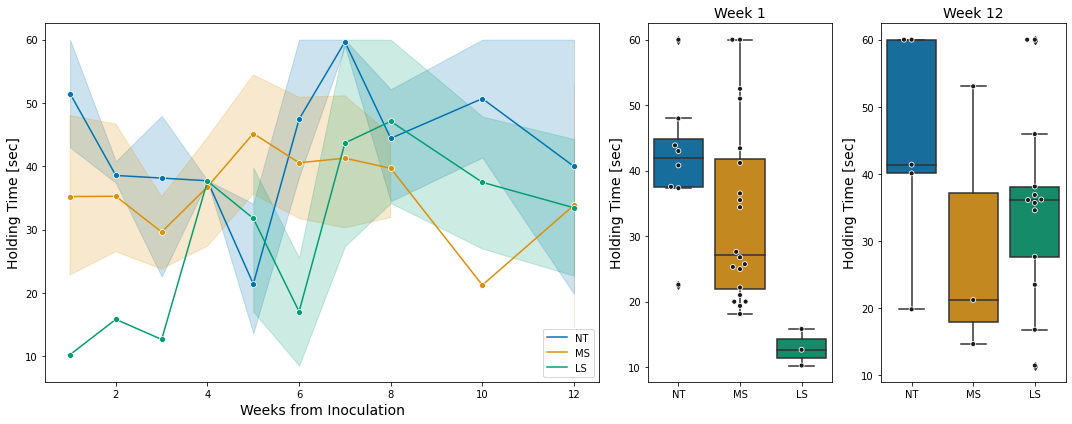

In [81]:
fig, ax = plt.subplots(1,3, figsize = (15,6), gridspec_kw={'width_ratios': [3, 1, 1]});
#g = sns.pointplot(data= df2, x = 'Week', y = 'MT', ax = ax[0], hue = 'Size', hue_order=sizeLabels, capsize = 0.1, palette = getPalette(df2, 'Size'));
g = sns.lineplot(data= df2, x = 'Week', y = 'MT', ax = ax[0], hue = 'Size', hue_order=sizeLabels, marker = 'o', palette = getPalette(df2, 'Size'));
ax[0].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[0].set_xlabel('Weeks from Inoculation', fontsize = 14)
g.legend_.set_title(None)
ax[0].legend(loc='lower right')

sns.boxplot(data= df2[(df2.Week <= 3)],  y = 'MT', ax = ax[1], x = 'Size', order=sizeLabels, palette = getPalette(df2, 'Size'));
sns.swarmplot(data= df2[(df2.Week <= 3)],  y = 'MT', ax = ax[1], x = 'Size', order=sizeLabels, color = 'k', edgecolor = 'white', linewidth=0.8, dodge=True);
ax[1].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[1].set_xlabel(' ', fontsize = 14)
ax[1].set_title('Week 1', fontsize = 14)

sns.boxplot(data= df2[(df2.Week >= 10)], y = 'MT', ax = ax[2], x = 'Size', order=sizeLabels, palette = getPalette(df2, 'Size'));
sns.swarmplot(data= df2[(df2.Week >= 10)],  y = 'MT', ax = ax[2], x = 'Size', order=sizeLabels, color = 'k', edgecolor = 'white', linewidth=0.8, dodge=True);
ax[2].set_ylabel('Holding Time [sec]', fontsize = 14)
ax[2].set_xlabel(' ', fontsize = 14)
ax[2].set_title('Week 12', fontsize = 14)


fname = picFolder + '/MT_size.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')
plt.show()

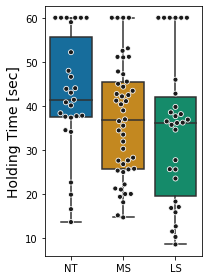

In [82]:
fig, ax = plt.subplots(1,1, figsize = (3,4));

#sns.boxplot(data = df2[(df2.Week == 7) |(df2.Week == 8) | (df2.Week == 9) | (df2.Week == 10) | (df2.Week == 11) | (df2.Week == 12)], x = 'Size', y = 'MT', ax = ax, palette = 'colorblind', order = sizeLabels);
sns.boxplot(data = df2, x = 'Size', y = 'MT', ax = ax, palette = getPalette(df2, 'Size'), order = sizeLabels);
sns.swarmplot(data = df2, x = 'Size', y = 'MT', ax = ax, color = 'k', edgecolor = 'white', linewidth=0.8, dodge = True);
ax.set_ylabel('Holding Time [sec]', fontsize = 14)
ax.set_xlabel(None)

fname = picFolder + '/MT_distrsize.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.show()


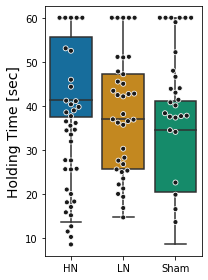

In [83]:
fig, ax = plt.subplots(1,1, figsize = (3,4));

sns.boxplot(data = df2, x = 'NCells', y = 'MT', ax = ax, palette = 'colorblind', order = nLabels);
sns.swarmplot(data = df2, x = 'NCells', y = 'MT', ax = ax, color = 'k', edgecolor = 'white', linewidth=0.8, dodge = True);
ax.set_ylabel('Holding Time [sec]', fontsize = 14)
ax.set_xlabel(None)

fname = picFolder + '/MT_distrNcells.png'    
#plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.tight_layout()
plt.show()


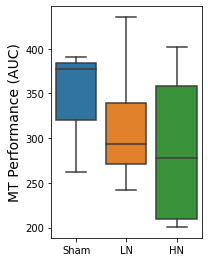

In [84]:
fig, ax = plt.subplots(1,1, figsize = (3,4));

auc = [];
ttx = [];

mice = np.unique(df2.Mouse[df2.NCells == 'Sham']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('Sham')
    
mice = np.unique(df2.Mouse[df2.NCells == 'LN']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('LN')
    
mice = np.unique(df2.Mouse[df2.NCells == 'HN']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('HN')

dummy = pd.DataFrame({'AUC': auc, 'Ttx': ttx});    

sns.boxplot(data = dummy, x = 'Ttx', y = 'AUC', ax = ax);
ax.set_ylabel('MT Performance (AUC)', fontsize = 14)
ax.set_xlabel(' ', fontsize = 14)

fname = picFolder + '/MT_performance.png'    
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.tight_layout()

plt.show();    

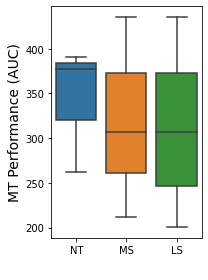

In [85]:
fig, ax = plt.subplots(1,1, figsize = (3,4));

auc = [];
ttx = [];

mice = np.unique(df2.Mouse[df2.Size == 'NT']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('NT')
    
mice = np.unique(df2.Mouse[df2.Size == 'MS']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('MS')
    
mice = np.unique(df2.Mouse[df2.Size == 'LS']);
for ix in range(len(mice)):
    auc.append(np.trapz(df2.MT[df2.Mouse == mice[ix]]));
    ttx.append('LS')

dummy = pd.DataFrame({'AUC': auc, 'Ttx': ttx});    

sns.boxplot(data = dummy, x = 'Ttx', y = 'AUC', ax = ax);
ax.set_ylabel('MT Performance (AUC)', fontsize = 14)
ax.set_xlabel(' ', fontsize = 14)

fname = picFolder + '/MT_performanceSize.png'    
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')
plt.tight_layout()

plt.show();    

In [86]:
#sns.pairplot(data= pcaDf, hue = 'Size')
#sns.pairplot(data= pcaDf[pcaDf.PC2 < 2.5], hue = 'Size')
#plt.show()

This procedure does ot capture the actual classes used in this study

## Behavior Panel:

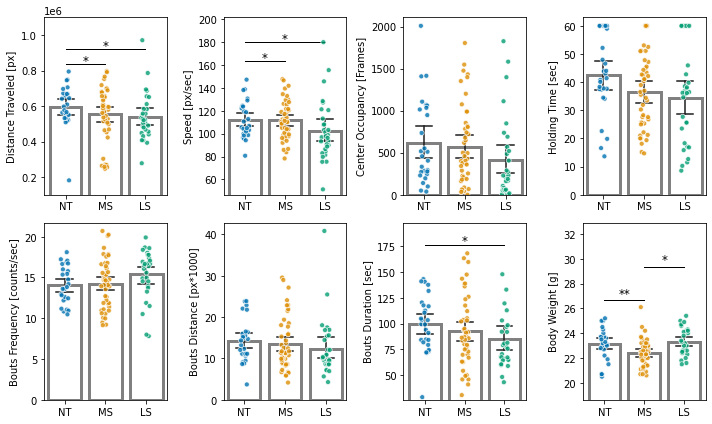

In [87]:
def runKruskal(df, var, ax, sizeLabels):
    # Identify and remove outliers using IQR method
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
    
    #df_filtered = df;
    
    #kruskal_result = f_oneway(*[df_filtered[var][df_filtered['Size'] == size] for size in df_filtered['Size'].unique()])
    kruskal_result = kruskal(*[df_filtered[var][df_filtered['Size'] == size] for size in df_filtered['Size'].unique()])
    if kruskal_result.pvalue < 0.05:
        posthoc = posthoc_dunn(df_filtered, val_col=var, group_col='Size')
        #posthoc = posthoc_dunn(df_filtered, val_col=var, group_col='Size')
        vals = posthoc.values
        sizeLabels = df_filtered['Size'].unique()
        
        # Find significant pairs and annotate the plot with the significance level        
        line_y = df_filtered[var].max()*1.05
        
        # Bonferroni correction: Adjust the significance threshold
        bonferroni_alpha = 0.05 / (len(sizeLabels) * (len(sizeLabels) - 1) / 2)
        
        for ix in range(len(sizeLabels)):
            for ij in range(ix + 1, len(sizeLabels)):
                p_value = vals[ix, ij]
                if p_value < bonferroni_alpha:
                    significance = "*"
                    if p_value <= 0.001:
                        significance = "**";
                    if p_value <= 0.0001:
                        significance = "***"                     
                    x_pos = (ix + ij) / 2
                    ax.text(x_pos, line_y * 1.02, significance, ha='center', va='center', fontsize=12)
                    ax.plot([ix, ij], [line_y, line_y], color='black', linestyle='-', linewidth=1)
                    line_y = line_y * 1.1
        ax.set_ylim([df2[var].min() / 1.1, line_y * 1.02])
    

fig, ax = plt.subplots(2,4,figsize = (10,6))

var = 'DistTrav'
h_ax = ax[0,0];
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels,
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylim([0.1e6, 1.1e6])
h_ax.set_ylabel('Distance Traveled [px]');

var = 'AvgSpeed'
h_ax = ax[0,1];
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylabel('Speed [px/sec]');

var = 'OccCenter'
h_ax = ax[0,2];
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
#h_ax.set_ylim([0, 0.8])
h_ax.set_xlabel(None);
h_ax.set_ylabel('Center Occupancy [Frames]');

var = 'BoutsFreq'
h_ax = ax[1,0]
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylabel('Bouts Frequency [counts/sec]');

var = 'BoutsDist'
h_ax = ax[1,1]
dummy = df2.copy();
dummy[var] = dummy[var]/1000;
sns.barplot(data= dummy, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = dummy, x = 'Size', y = var, ax = h_ax, palette = getPalette(dummy, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(dummy, var, h_ax, sizeLabels)
ax[1,1].set_xlabel(None);
ax[1,1].set_ylabel('Bouts Distance [px*1000]');

var = 'BoutsDur'
h_ax = ax[1,2]
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylabel('Bouts Duration [sec]');

var = 'MT'
h_ax = ax[0,3]
#sel = (df2.Week == 1) | (df2.Week == 2) | (df2.Week == 3) | (df2.Week == 4) 
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor="k",errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylabel('Holding Time [sec]');

var = 'Weight'
h_ax = ax[1,3]
sns.barplot(data= df2, x = 'Size', y = var, ax = h_ax, order = sizeLabels, 
            capsize=.4, errcolor= 'k',errwidth=1.5, linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0));
sns.stripplot(data = df2, x = 'Size', y = var, ax = h_ax, palette = getPalette(df2, 'Size'), alpha=.8, edgecolor = 'white', linewidth=0.8, dodge = True);
runKruskal(df2, var, h_ax, sizeLabels)
h_ax.set_xlabel(None);
h_ax.set_ylabel('Body Weight [g]');

fname = picFolder + '/Beh_Panel.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor='auto')

plt.show();  

## Distribution of behavioral data 

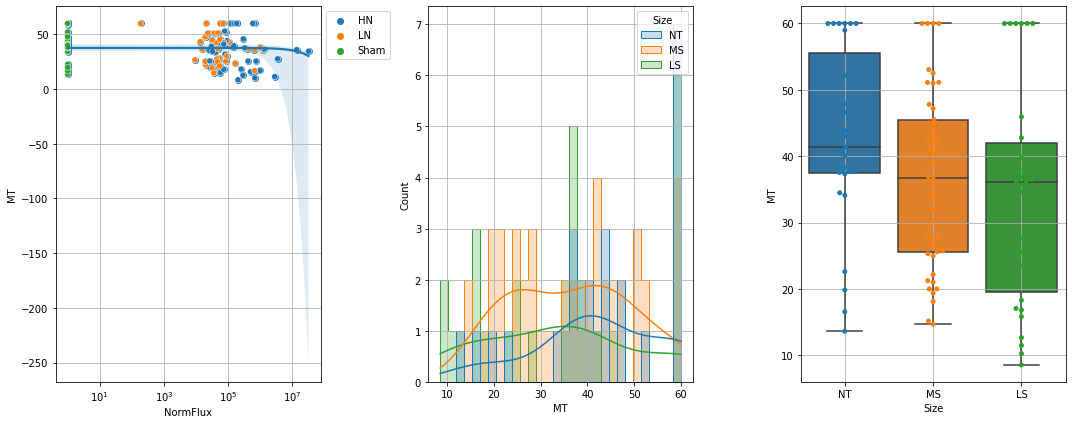

In [88]:
var = 'MT';

fig, ax = plt.subplots(1,3, figsize = (15,6));
sns.regplot(data= df2, x = 'NormFlux', y = var, ax = ax[0]);
#sns.scatterplot(data= df2, x = 'NormFlux', y = var, hue = 'Size', ax = ax[0], hue_order= sizeLabels);
sns.scatterplot(data= df2, x = 'NormFlux', y = var, hue = 'NCells', ax = ax[0]);
ax[0].set_xscale('log')
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].grid()

sns.histplot(data= df2, x = var, bins = 30, log_scale = False, kde = True, ax = ax[1], element = 'step', hue = 'Size');

#ax.set_xscale('log')
#ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].grid()

sns.boxplot(data= df2, x = 'Size', y = var, ax = ax[2], order = sizeLabels);
#sns.swarmplot(data= df2, x = 'Size', y = var, ax = ax[2], order = sizeLabels, color='black');
sns.swarmplot(data= df2, x = 'Size', y = var, ax = ax[2], order = sizeLabels);
#ax.set_xscale('log')
ax[2].grid()
plt.tight_layout()


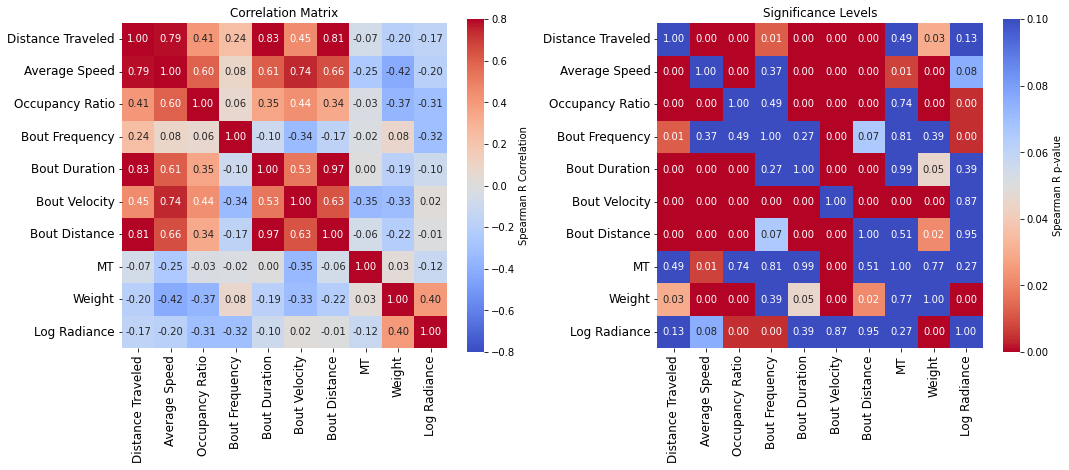

In [89]:
analysisFolder = '/Users/sbk/Documents/IVRS/Ruta/';

df4 = pd.read_excel(analysisFolder + 'Correlation.xlsx', sheet_name='Sheet2')
df5 = pd.read_excel(analysisFolder + 'Correlation.xlsx', sheet_name='Sheet3')

df4.rename(columns = {'Bout Frequency': 'Bouts Freq', 'Bout Duration':'Bouts Dur', 'Bout Velocity': 'Bouts Speed'})
df5.rename(columns = {'Bout Frequency': 'Bouts Freq', 'Bout Duration':'Bouts Dur', 'Bout Velocity': 'Bouts Speed'})
# Correlation matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

features = df4.columns
# Plot correlation matrix heatmap
sns.heatmap(df4, annot=True, fmt='.2f', ax=ax1, cmap='coolwarm', vmin=-0.8, vmax=0.8,
            xticklabels=features, yticklabels=features, 
            square=True, cbar_kws={"shrink": .82, 'label': 'Spearman R Correlation'})
ax1.set_title('Correlation Matrix')
ax1.tick_params(axis='both', labelsize=12)

cmap_reversed = plt.cm.get_cmap('coolwarm_r')
sns.heatmap(df5, annot=True, fmt='.2f', cmap = cmap_reversed, cbar=True, ax=ax2, 
            vmin = 0, vmax = 0.1, xticklabels= features, yticklabels= features, 
            square=True, cbar_kws={"shrink": .82, 'label': 'Spearman R p-value'})
ax2.set_title('Significance Levels')
ax2.tick_params(axis='both', labelsize=12)

# Save and show the plot
plt.tight_layout()
plt.savefig(picFolder +  '/CorrMatrix.tiff', dpi= 200, format='tiff',
        bbox_inches= 'tight', pad_inches=0.1, facecolor='white', edgecolor= None)
plt.show()

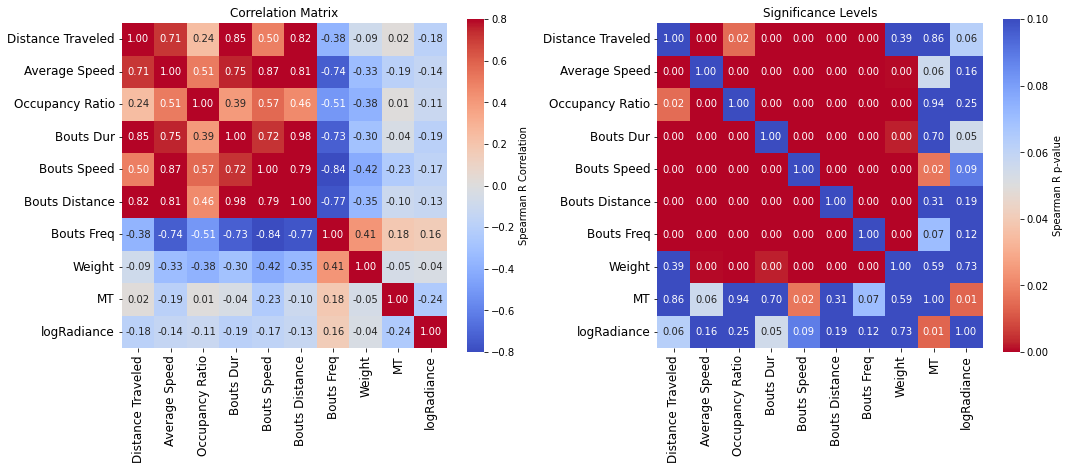

In [90]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def calculate_p_values(data):
    _, num_features = data.shape
    p_values = np.zeros((num_features, num_features))

    for i in range(num_features):
        for j in range(num_features):
            if i == j: 
                p_values[i, j] = 1
            else:
                corr, p_value = pearsonr(data.iloc[:, i], data.iloc[:, j])
                p_values[i, j] = p_value

    return p_values

# Correlation matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Calculate correlation matrix
scaler = StandardScaler()
features = ['DistTrav', 'AvgSpeed', 'OccRatio', 'BoutsDur', 'BoutsVel', 'BoutsDist', 'BoutsFreq', 'Weight','MT', 'logRadiance']
X = df2.loc[:, features]
X.rename(columns = {'DistTrav': 'Distance Traveled', 'AvgSpeed':'Average Speed',
                    'OccRatio': 'Occupancy Ratio', 
                    'BoutsDist': 'Bouts Distance', 
                    'BoutsFreq': 'Bouts Freq', 
                    'BoutsDur':'Bouts Dur', 
                    'BoutsVel': 'Bouts Speed'}, inplace = True)

#result = scaler.fit_transform(X)
#X = pd.DataFrame(result, columns = features)
c_matrix = pd.DataFrame.corr(X.astype('float'), method = 'pearson')

# Plot correlation matrix heatmap
sns.heatmap(c_matrix, annot=True, fmt='.2f', ax=ax1, cmap='coolwarm', vmin=-0.8, vmax=0.8, 
            square=True, cbar_kws={"shrink": .82, 'label': 'Spearman R Correlation'})
ax1.set_title('Correlation Matrix')
ax1.tick_params(axis='both', labelsize=12)

# Plot significance levels
p_values = calculate_p_values(X)  # Replace with your own function to calculate p-values
significance_levels = np.zeros_like(c_matrix)
significance_levels[p_values < 0.01] = 1  # Set significance level as 1 for p-values < 0.05
c_matrix = pd.DataFrame(p_values, columns = features)
cmap_reversed = plt.cm.get_cmap('coolwarm_r')
sns.heatmap(c_matrix, annot=True, fmt='.2f', cmap = cmap_reversed, cbar=True, ax=ax2, 
            vmin = 0, vmax = 0.1, xticklabels= list(X.columns), yticklabels= list(X.columns), 
            square=True, cbar_kws={"shrink": .82, 'label': 'Spearman R p-value'})
ax2.set_title('Significance Levels')
ax2.tick_params(axis='both', labelsize=12)
#ax2.set_yticklabels(features)
# Adjust the layout to make room for the second subplot
#plt.subplots_adjust(wspace=0.5)

# Save and show the plot
fname = picFolder + '/CorrMatrix2.tiff'
# Save and show the plot
plt.tight_layout()
plt.savefig(fname, dpi= 200, format='tiff',
        bbox_inches= 'tight', pad_inches=0.1, facecolor='white', edgecolor= None)
plt.show()

## Machine Learning models:

In [185]:
# Extract the features (independent variables) and the target (dependent variable)
y = df2.logRadiance;
bX = df2.drop(columns = ['NormFlux', 'logRadiance', 'Mouse', 'Unnamed: 0', 'NCells', 'Date_x', 'Date_y', 'Week',
                        'OccCenter', 'OccPeri', 'Group', 'Batch', 'Treatment', 'TotalFlux', 'Avg-BKG Flux',
                        'Comments', 'MTScore', 'Size', 'SizeScore', 'Weight'])
bX.reset_index(drop = True, inplace = True);
features_names = list(bX.columns);


X = StandardScaler().fit_transform(bX)

# Add random noise to X_train and y_train
noise_level = 0.1  # Adjust as needed
augX = X + np.random.normal(0, noise_level, X.shape)
augy = y + np.random.normal(0, noise_level, y.shape)
augX = np.vstack((X, augX))
augy = np.concatenate((y, augy))

augX = augX + np.random.normal(0, noise_level, augX.shape)
augy = augy + np.random.normal(0, noise_level, augy.shape)
augX = np.vstack((X, augX))
augy = np.concatenate((y, augy))


In [159]:
#to plot the output performance of the models:
def plotReg(y,y_pred,hax):
    bcolor = np.ones(len(y))
    bcolor[(y>0) & (y<5)] = 2
    bcolor[(y>=5)] = 3
    dummy = pd.DataFrame({'y': y, 'y_pred': y_pred, 'Size': bcolor})
        
    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Calculate p-value
    slope, intercept, r_value, p_value, std_err = linregress(y, y_pred)

    # Plot:
    sns.regplot(data=dummy, x='y', y='y_pred', ax = hax, x_ci= 'ci', ci = 95)
    sns.scatterplot(data=dummy, x='y', y='y_pred', ax=hax, hue='Size', s=100)
    hax.set_xlabel('Actual Values', fontsize = 14)
    hax.set_ylabel('Predicted Values', fontsize = 14)

    coef = np.polyfit(y, y_pred, 1)
    poly1d_fn = np.poly1d(coef)
    hax.plot(y, poly1d_fn(y), 'b-', label = f'Trend Line: r = {r_value:.2f}; p = {p_value:.2f}')
    hax.plot(y, y, 'r', label = 'Perfect Match')
    hax.legend(title = None, loc = 'upper left')

    # Add box annotation
    bbox_props = dict(boxstyle="round", fc="white", ec="gray", alpha=0.8)
    #textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \nMBD: {mbd:.2f} \n$R^2$: {r2:.2f} \nAdj $R^2$: {adjusted_r2:.2f} \np-value: {p_value:.3f}'
    textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \n$R^2$: {r2:.2f}\n'
    hax.text(0.8, 0.05, textstr, transform=hax.transAxes, fontsize=10, verticalalignment='bottom', bbox=bbox_props)
    hax.tick_params(axis='both', labelsize=12)
    hax.grid(True)


![Alt text](https://scikit-learn.org/stable/_images/grid_search_workflow.png "model training workflow")

https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline


X_train, X_test, y_train, y_test = train_test_split(augX, augy, test_size=0.2, random_state=42)

# Feature selection (you can customize this step)
selector = SelectKBest(f_regression, k='all')
kf = RepeatedKFold(n_splits=5, n_repeats = 10, random_state=42)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Models to evaluate
models = [
    ('LR', LinearRegression()),
    ('LLR', Lasso()),
    ('KNN', KNeighborsRegressor()),
    ('RF', RandomForestRegressor()),
    ('DT', DecisionTreeRegressor()),
    ('GB', GradientBoostingRegressor()),
    ('XGB', XGBRegressor()),
]

bModels = [] #to collect the best models

# Evaluate and visualize models
for model_name, model in models[0:4]:
    model_pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    # Hyperparameter tuning using Grid Search and Cross-Validation
    param_grid = {}
    if model_name == 'GB':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
            'model__learning_rate': [1, 0.1, 0.01]
        }
    elif model_name == 'XGB':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__learning_rate': [1, 0.1, 0.01]
        }
    elif model_name == 'RF':
        param_grid = {
            'model__n_estimators': [100, 500, 1000],
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
        }
    elif model_name == 'DT':
        param_grid = {
            'model__max_depth': [3, 5, 6],
            'model__max_features': [3, 5, 7],
        }
    elif model_name == 'LLR':
        param_grid = {
            'model__alpha': [1, 0.5, 0.1],
        }
    elif model_name == 'KNN':
        param_grid = {
            'model__n_neighbors': [1, 3, 5, 10, 20],
        }

    print(f'Current model: {model_name}', end="\r")

    grid_search = GridSearchCV(model_pipeline, param_grid, cv=kf, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    bModels.append([model_name, best_model, best_params])
    

Model: LR
Best Parameters: {}
Mean Squared Error: 7.99877017962783
R-squared (R²): -0.6882414454573131


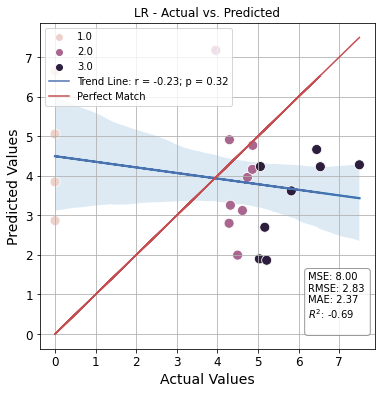

Model: LLR
Best Parameters: {'model__alpha': 0.1}
Mean Squared Error: 5.3559195006343225
R-squared (R²): -0.13043443885077521


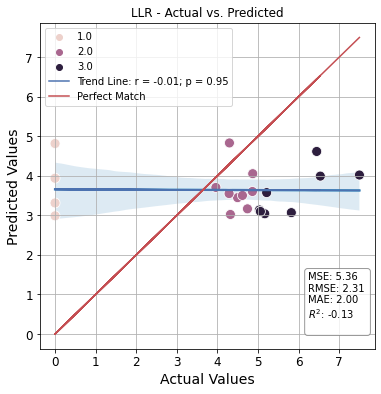

Model: KNN
Best Parameters: {'model__n_neighbors': 5}
Mean Squared Error: 5.9406650609487475
R-squared (R²): -0.2538523728332094


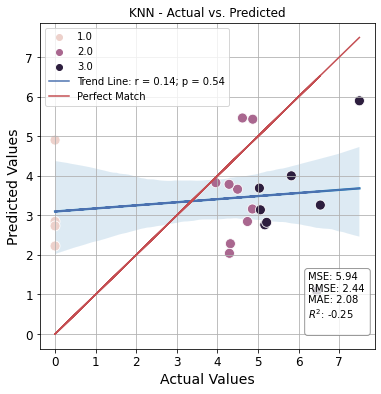

Model: RF
Best Parameters: {'model__max_depth': 5, 'model__max_features': 3, 'model__n_estimators': 1000}
Mean Squared Error: 5.085491520845225
R-squared (R²): -0.07335719907033544


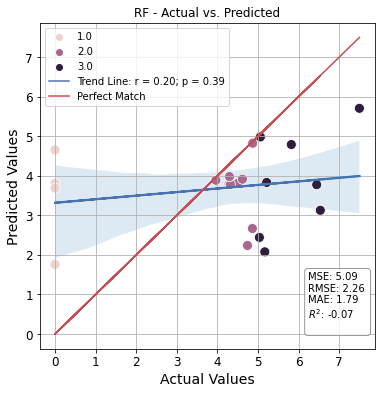

Model: DT
Best Parameters: {'model__max_depth': 3, 'model__max_features': 5}
Mean Squared Error: 7.111111676389443
R-squared (R²): -0.5008899100429807


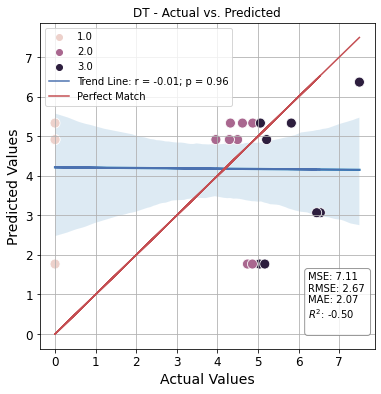

Model: GB
Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__max_features': 3, 'model__n_estimators': 100}
Mean Squared Error: 5.51771366202815
R-squared (R²): -0.1645831395590105


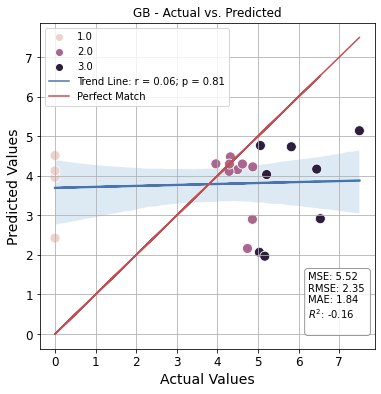

Model: XGB
Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 500}
Mean Squared Error: 5.476395685870926
R-squared (R²): -0.15586245897630024


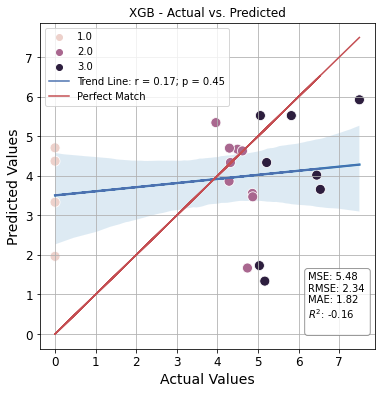

In [170]:
# Make predictions and calculate metrics
for model_name, best_model, best_params in bModels:
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print and visualize results
    print(f'Model: {model_name}')
    print(f'Best Parameters: {best_params}')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared (R²): {r2}')

    fig, ax = plt.subplots(1,1,figsize=(6, 6))
    plotReg(y_test,y_pred,ax)
    plt.title(f"{model_name} - Actual vs. Predicted")
    plt.show()

Accuracy: 52.38%


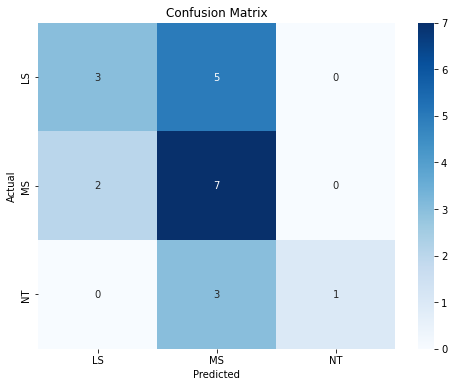

In [164]:
# Import the necessary libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your dataset (replace 'your_data.csv' with your data file)
import pandas as pd

# Split the dataset into features (X) and target (y)
y = df2.Size;
bX = df2.drop(columns = ['NormFlux', 'logRadiance', 'Mouse', 'Unnamed: 0', 'NCells', 'Date_x', 'Date_y', 'Week',
                        'OccCenter', 'OccPeri', 'Group', 'Batch', 'Treatment', 'TotalFlux', 'Avg-BKG Flux',
                        'Comments', 'MTScore', 'Size', 'SizeScore', 'Weight'])
bX.reset_index(drop = True, inplace = True);
features_names = list(bX.columns);
X = StandardScaler().fit_transform(bX)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bClassifier = RandomForestClassifier(max_depth = 3, max_features = 3, n_estimators = 1000)
#bClassifier = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_depth=4)

# Train (fit) the classifier on the training data
bClassifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = bClassifier.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Create a confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot a heatmap of the confusion matrix
class_names = np.unique(y)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


The choice of the evaluation metric to determine the best model depends on the specific problem you are trying to solve and the characteristics of your dataset. Here's a brief explanation of when to use each of the mentioned metrics:

1. **Mean Squared Error (MSE)**: MSE is a common choice for regression problems. It measures the average squared difference between the predicted values and the actual values. Lower MSE indicates better model performance. MSE is sensitive to outliers and gives more weight to larger errors.

2. **Root Mean Squared Error (RMSE)**: RMSE is the square root of the MSE. It has the same interpretation as the original data's units, which can make it easier to understand. Like MSE, lower RMSE values indicate better performance. RMSE is also sensitive to outliers.

3. **R-squared (R2)**: R-squared measures the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). It ranges from 0 to 1, with higher values indicating better model fit. R-squared of 1 means the model explains all the variance, while an R-squared of 0 means it doesn't explain any.

The choice between these metrics depends on your specific goals:

- Use **MSE or RMSE** when you want to directly measure the accuracy of your model's predictions in terms of the original data scale. These metrics are appropriate if you want to penalize larger errors more heavily.

- Use **R2** when you want to understand how well your model explains the variance in the target variable. It provides a measure of goodness of fit. R2 is particularly useful when you need to compare different models or assess how much of the variability in the target variable is captured by your model.

In practice, it's often a good idea to consider multiple metrics to get a more comprehensive view of your model's performance. For example, you might look at both RMSE and R2 to assess predictive accuracy and model fit simultaneously.

Ultimately, the choice of the best metric depends on your specific problem and what aspect of model performance you want to prioritize.

In [ ]:
# Create empty lists to store the results and models
lr_mse, lr_rmse, lr_r2 = [], [], []
Llr_mse, Llr_rmse, Llr_r2 = [], [], []
GB_mse, GB_rmse, GB_r2 = [], [], []
RF_mse, RF_rmse, RF_r2 = [], [], []
XGB_mse, XGB_rmse, XGB_r2 = [], [], []
DT_mse, DT_rmse, DT_r2 = [], [], []
KNN_mse, KNN_rmse, KNN_r2 = [], [], [] 

LR, LLR, KNN, GB, XGB, RF, DT = [], [], [], [], [], [], []

# Define the number of cross-validation folds and iterations
num_folds = 5
num_iter = 20

# Set up the KFold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True)

for i in range(num_iter):
    mse1, rmse1, r21 = [], [], []
    mse2, rmse2, r22 = [], [], []
    mse3, rmse3, r23 = [], [], []
    mse4, rmse4, r24 = [], [], []
    mse5, rmse5, r25 = [], [], []
    mse6, rmse6, r26 = [], [], []
    mse7, rmse7, r27 = [], [], []

    bLR, bLLR, bKNN, bGB, bXGB, bRF, bDT = [], [], [], [], [], [], []

    # Split the data into training and testing sets for each fold
    for k, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the linear regression model and calculate metrics
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred1 = lr.predict(X_test)
        mse1.append(mean_squared_error(y_test, y_pred1))
        rmse1.append(np.sqrt(mse1[k]))
        r21.append(r2_score(y_test, y_pred1))

        # Fit the Lasso regression model and calculate metrics
        param_grid = {'alpha': [1.0, 0.8, 0.5, 0.3, 0.1]}
        Llr = Lasso()
        Llr_cv = GridSearchCV(Llr, param_grid, scoring = 'neg_mean_squared_error')
        Llr_cv.fit(X_train, y_train)
        Llr.set_params(**Llr_cv.best_params_)
        Llr.fit(X_train, y_train)
        y_pred2 = Llr.predict(X_test)
        mse2.append(mean_squared_error(y_test, y_pred2))
        rmse2.append(np.sqrt(mse2[k]))
        r22.append(r2_score(y_test, y_pred2))

        # Fit the Gradient Boosting regression model and calculate metrics        
        #gb = GridSearchCV(gb, param_grid, scoring='neg_mean_squared_error')
        gb = GradientBoostingRegressor(n_estimators = 1000, max_depth = 6, max_features = 3, learning_rate = 0.01)
        gb.fit(X_train, y_train)
        y_pred3 = gb.predict(X_test)
        mse3.append(mean_squared_error(y_test, y_pred3))
        rmse3.append(np.sqrt(mse3[k]))
        r23.append(r2_score(y_test, y_pred3))
        
        # Fit the Random Forest regression model and calculate metrics
        param_grid = {
            'n_estimators': [100, 500, 1000],    # Number of trees
            'max_depth': [3, 6, 9],               # Maximum depth of trees
            'max_features': [3, 5, 7]             # Maximum features per split
        }
        rf = RandomForestRegressor(n_estimators = 1000, max_depth = 6, max_features = 3)
        #rf = RandomForestRegressor()
        #rf = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error')
        rf.fit(X_train, y_train)
        y_pred4 = rf.predict(X_test)
        mse4.append(mean_squared_error(y_test, y_pred4))
        rmse4.append(np.sqrt(mse4[k]))
        r24.append(r2_score(y_test, y_pred4))
        
        xgb = XGBRegressor(n_estimators = 1000, max_depth = 6, learning_rate = 0.01)
        xgb.fit(X_train, y_train)
        y_pred5 = gb.predict(X_test)
        mse5.append(mean_squared_error(y_test, y_pred5))
        rmse5.append(np.sqrt(mse5[k]))
        r25.append(r2_score(y_test, y_pred5))
        
        dt = DecisionTreeRegressor(max_depth = 6, max_features = 3)
        dt.fit(X_train, y_train)
        y_pred6 = rf.predict(X_test)
        mse6.append(mean_squared_error(y_test, y_pred6))
        rmse6.append(np.sqrt(mse6[k]))
        r26.append(r2_score(y_test, y_pred6))
        
        knn = KNeighborsRegressor(n_neighbors=10)  # You can adjust the number of neighbors (n_neighbors) as needed
        knn.fit(X_train, y_train)
        y_pred7 = knn.predict(X_test)
        mse7.append(mean_squared_error(y_test, y_pred7))
        rmse7.append(np.sqrt(mse7[k]))
        r27.append(r2_score(y_test, y_pred7))
        
        #collect the models
        bLR.append(lr)
        bLLR.append(Llr)
        bGB.append(gb)
        bRF.append(rf)
        bXGB.append(xgb)
        bDT.append(dt)
        bKNN.append(knn)

    # Store the best result of the model for each iteration
    LR.append(bLR[np.argmax(r21)])
    LLR.append(bLLR[np.argmax(r22)])
    GB.append(bGB[np.argmax(r23)])
    RF.append(bRF[np.argmax(r24)])
    XGB.append(bXGB[np.argmax(r25)])
    DT.append(bDT[np.argmax(r26)])
    KNN.append(bKNN[np.argmax(r27)])
    
    # Store the average metrics for each model
    lr_mse.append(np.mean(mse1))
    lr_rmse.append(np.mean(rmse1))
    lr_r2.append(np.mean(r21))
    Llr_mse.append(np.mean(mse2))
    Llr_rmse.append(np.mean(rmse2))
    Llr_r2.append(np.mean(r22))
    GB_mse.append(np.mean(mse3))
    GB_rmse.append(np.mean(rmse3))
    GB_r2.append(np.mean(r23))
    RF_mse.append(np.mean(mse4))
    RF_rmse.append(np.mean(rmse4))
    RF_r2.append(np.mean(r24))
    XGB_mse.append(np.mean(mse5))
    XGB_rmse.append(np.mean(rmse5))
    XGB_r2.append(np.mean(r25))
    DT_mse.append(np.mean(mse6))
    DT_rmse.append(np.mean(rmse6))
    DT_r2.append(np.mean(r26))        
    KNN_mse.append(np.mean(mse7))
    KNN_rmse.append(np.mean(rmse7))
    KNN_r2.append(np.mean(r27)) 

    
    

AttributeError: 'Series' object has no attribute 'feature_importances_'

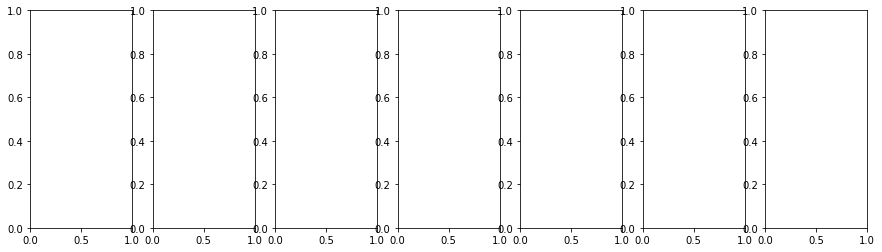

In [ ]:
#FEATURES SELECTION FROM THE BEST TRAINED MODELS:

fig, ax = plt.subplots(1,7, figsize=(15, 4), sharey = False)

hax = ax[0]
bModel = Mdf.xmodel[Mdf.Model == 'RF']
idx = np.argsort(bModel.feature_importances_)
hax.barh(np.take(features_names, idx), np.take(bModel.feature_importances_, idx))
hax.set_yticks(range(X.shape[1]), np.take(features_names, idx))
hax.set_title('RF')

hax = ax[1]
bModel = Mdf.xmodel[Mdf.Model == 'GB']
hax.barh(np.take(features_names, idx), np.take(bModel.feature_importances_, idx))
hax.set_yticks(range(X.shape[1]), np.take(features_names, idx))
hax.set_title('GB')

hax = ax[2]
bModel = Mdf.xmodel[Mdf.Model == 'XGB']
hax.barh(np.take(features_names, idx), np.take(bModel.feature_importances_, idx))
hax.set_yticks(range(X.shape[1]), np.take(features_names, idx))
hax.set_title('XGB')

hax = ax[3]
bModel = Mdf.xmodel[Mdf.Model == 'DT']
hax.barh(np.take(features_names, idx), np.take(bModel.feature_importances_, idx))
hax.set_yticks(range(X.shape[1]), np.take(features_names, idx))
hax.set_title('DT')

# K-Nearest Neighbors (KNN) Feature Importance
hax = ax[4]
bModel = Mdf.xmodel[Mdf.Model == 'KNN']
feature_importance = np.zeros(X.shape[1])

# Calculate feature importance by measuring the change in MSE when each feature is removed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
baseline_mse = mean_squared_error(y_test, bModel.predict(X_test))
for feature_idx in range(X.shape[1]):
    X_test_without_feature = X_test.copy()
    X_test_without_feature[:, feature_idx] = np.mean(X_test_without_feature[:, feature_idx])  # Replace with feature mean
    mse_without_feature = mean_squared_error(y_test, bModel.predict(X_test_without_feature))
    feature_importance[feature_idx] = abs(baseline_mse - mse_without_feature)

hax.barh(np.take(features_names, idx), np.take(feature_importance, idx))
hax.set_yticks(range(X.shape[1]), np.take(features_names, idx))
hax.set_title('KNN')


hax = ax[5]
bModel = Mdf.xmodel[Mdf.Model == 'LR']
coefficients = bModel.coef_
hax.barh(np.take(features_names, idx), np.take(coefficients, idx))
hax.set_yticks(range(X.shape[1]), np.take(features_names, idx))
hax.set_title('LR')

hax = ax[6]
bModel = Mdf.xmodel[Mdf.Model == 'LLR']
coefficients = bModel.coef_
hax.barh(np.take(features_names, idx), np.take(coefficients, idx))
hax.set_yticks(range(X.shape[1]), np.take(features_names, idx))
hax.set_title('Lasso')

plt.tight_layout()
plt.show()


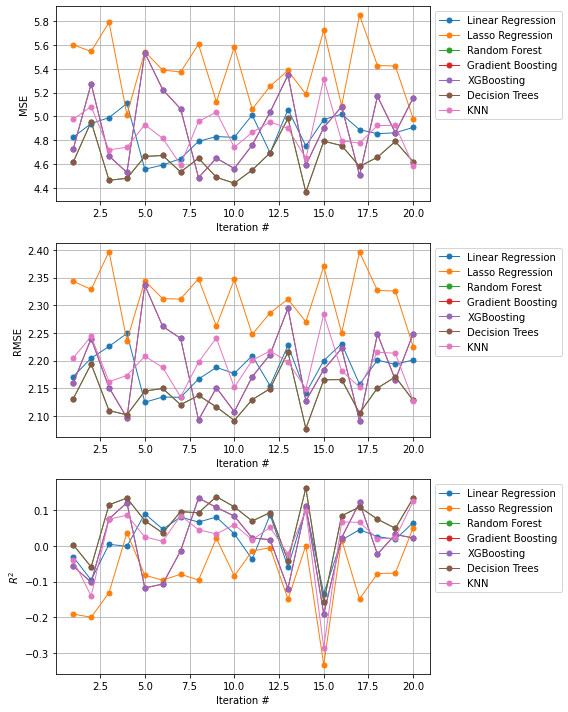

In [ ]:
fig,ax = plt.subplots(3,1,figsize = (8,10));

labels = ['Linear Regression', 'Lasso Regression', 'Gradient Boosting', 'Random Forest', 'XGBoosting', 'Decision Trees', 'KNN'];

iteration = range(1,21);
ax[0].plot(iteration,lr_mse, label= labels[0], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,Llr_mse, label= labels[1], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,RF_mse, label= labels[3], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,GB_mse,label= labels[2], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,XGB_mse,label= labels[4], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,DT_mse,label= labels[5], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,KNN_mse,label= labels[6], marker='o',linewidth=1, markersize=5)
ax[0].set_ylabel("MSE")
ax[0].set_xlabel("Iteration #")
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].grid()

ax[1].plot(iteration,lr_rmse, label=labels[0],marker='o', linewidth=1, markersize=5)
ax[1].plot(iteration,Llr_rmse, label=labels[1],marker='o', linewidth=1, markersize=5)
ax[1].plot(iteration,RF_rmse, label=labels[3],marker='o', linewidth=1, markersize=5)
ax[1].plot(iteration,GB_rmse, label=labels[2],marker='o', linewidth=1, markersize=5)
ax[1].plot(iteration,XGB_rmse,label= labels[4], marker='o',linewidth=1, markersize=5)
ax[1].plot(iteration,DT_rmse,label= labels[5], marker='o',linewidth=1, markersize=5)
ax[1].plot(iteration,KNN_rmse,label= labels[6], marker='o',linewidth=1, markersize=5)
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Iteration #")
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].grid()

ax[2].plot(iteration,lr_r2,label=labels[0],marker='o', linewidth=1, markersize=5)
ax[2].plot(iteration,Llr_r2,label=labels[1],marker='o', linewidth=1, markersize=5)
ax[2].plot(iteration,RF_r2,label=labels[3],marker='o',linewidth=1, markersize=5)
ax[2].plot(iteration,GB_r2,label=labels[2],marker='o',linewidth=1, markersize=5)
ax[2].plot(iteration,XGB_r2,label= labels[4], marker='o',linewidth=1, markersize=5)
ax[2].plot(iteration,DT_r2,label= labels[5], marker='o',linewidth=1, markersize=5)
ax[2].plot(iteration,KNN_r2,label= labels[6], marker='o',linewidth=1, markersize=5)
ax[2].set_ylabel("$R^2$")
ax[2].set_xlabel("Iteration #")
ax[2].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[2].grid()


fname = picFolder + '/ModelError.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')
plt.show()

Linear Regression p-val = 0.0000
Lasso Regression p-val = 0.0005
K-Nearest Neighbors p-val = 0.0000
Decision Trees p-val = 0.0000


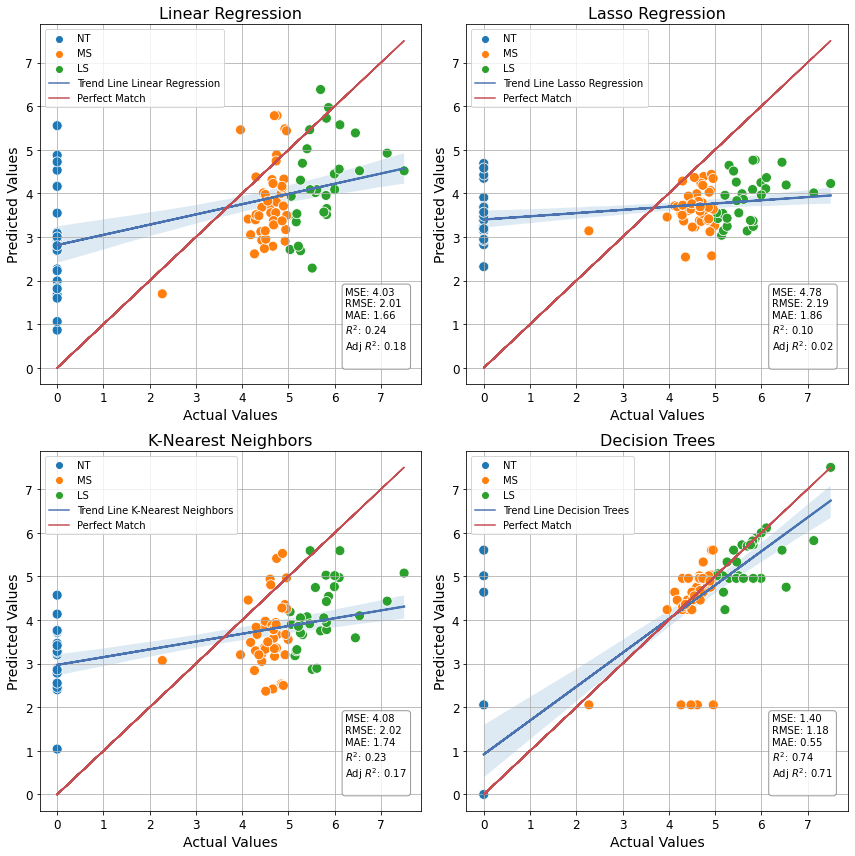

In [ ]:
# chosen iterations (the highest R2):
labels = ['Linear Regression', 'Lasso Regression', 'K-Nearest Neighbors', 'Decision Trees']
lr = LR[np.argmax(lr_r2)]
Llr = LLR[np.argmax(Llr_r2)]
knn = KNN[np.argmax(KNN_r2)]
dt = DT[np.argmax(DT_r2)]

model = [lr, Llr, knn, dt]
# predict prices with the models:
y_pred = [lr.predict(X), Llr.predict(X), knn.predict(X), dt.predict(X)]

pos = [[0,0], [0,1], [1,0], [1,1]];

# plot:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for ix in range(len(y_pred)):
    dummy = pd.DataFrame({'y': y, 'y_pred': y_pred[ix], 'Size': df2.Size, 'Week': df2.Week})
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred[ix])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred[ix])
    r2 = r2_score(y, y_pred[ix])
    adjusted_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - X.shape[1] - 1)
    mbd = np.mean(y_pred[ix] - y)
    
    # Calculate p-value
    slope, intercept, r_value, p_value, std_err = linregress(y, y_pred[ix])

    # Plot:
    h_ax = ax[pos[ix][0], pos[ix][1]]
    sns.regplot(data=dummy, x='y', y='y_pred', ax = h_ax, x_ci= 'ci', ci = 95)
    sns.scatterplot(data=dummy, x='y', y='y_pred', ax=h_ax, hue='Size', hue_order=sizeLabels, s=100)
    h_ax.set_xlabel('Actual Values', fontsize = 14)
    h_ax.set_ylabel('Predicted Values', fontsize = 14)
    
    coef = np.polyfit(y, y_pred[ix], 1)
    poly1d_fn = np.poly1d(coef)
    h_ax.plot(y, poly1d_fn(y), 'b-', label = f'Trend Line {labels[ix]}')
    h_ax.plot(y, y, 'r', label = 'Perfect Match')
    h_ax.legend(title = None, loc = 'upper left')
    
    # Add box annotation
    bbox_props = dict(boxstyle="round", fc="white", ec="gray", alpha=0.8)
    #textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \nMBD: {mbd:.2f} \n$R^2$: {r2:.2f} \nAdj $R^2$: {adjusted_r2:.2f} \np-value: {p_value:.3f}'
    textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \n$R^2$: {r2:.2f} \nAdj $R^2$: {adjusted_r2:.2f} \n'
    h_ax.text(0.8, 0.05, textstr, transform=h_ax.transAxes, fontsize=10,
                verticalalignment='bottom', bbox=bbox_props)
    h_ax.tick_params(axis='both', labelsize=12)

    h_ax.set_title(f'{labels[ix]}', fontsize = 16)
    h_ax.grid(True)
    
    print(f'{labels[ix]} p-val = {p_value:.4f}')

fname = picFolder + '/ModelOutput1.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')
plt.show()

Gradient Boosting p-val = 0.0000
XGBoosting p-val = 0.0000
Random Forest p-val = 0.0000


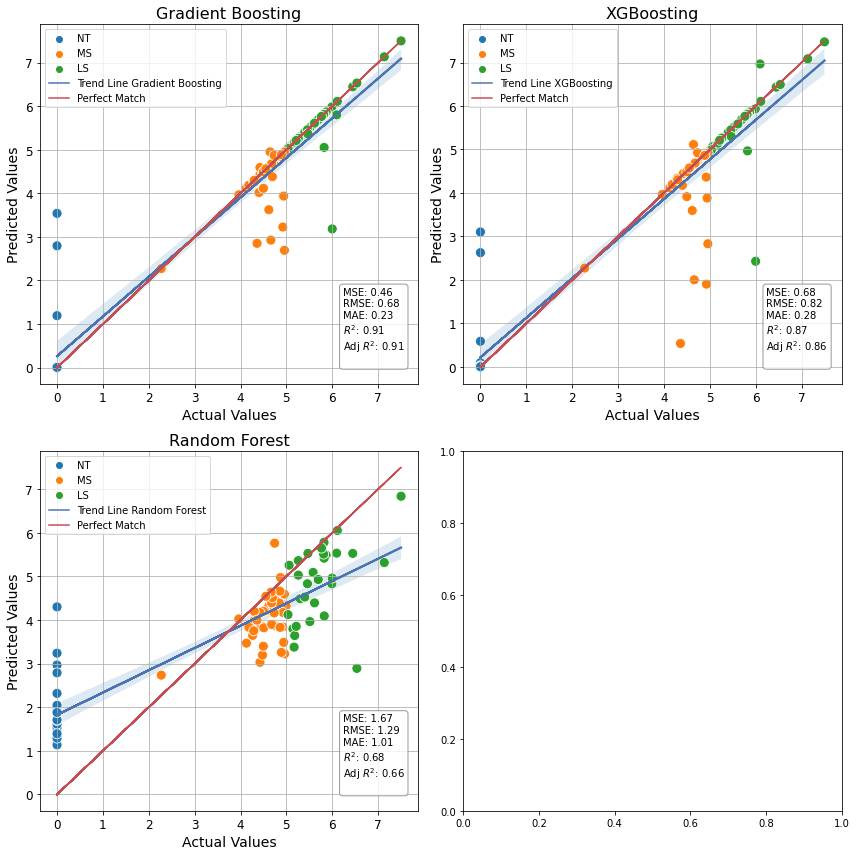

In [ ]:
# chosen iterations (the highest R2):
labels = ['Gradient Boosting', 'XGBoosting', 'Random Forest']
gb = GB[np.argmax(GB_r2)]
xgb = XGB[np.argmax(XGB_r2)]
rf = RF[np.argmax(RF_r2)]

model = [gb, xgb, rf]
# predict prices with the models:
y_pred = [gb.predict(X), xgb.predict(X), rf.predict(X)]

pos = [[0,0], [0,1], [1,0], [1,1]];

# plot:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for ix in range(len(y_pred)):
    dummy = pd.DataFrame({'y': y, 'y_pred': y_pred[ix], 'Size': df2.Size, 'Week': df2.Week})
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred[ix])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred[ix])
    r2 = r2_score(y, y_pred[ix])
    adjusted_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - X.shape[1] - 1)
    mbd = np.mean(y_pred[ix] - y)
    
    # Calculate p-value
    slope, intercept, r_value, p_value, std_err = linregress(y, y_pred[ix])

    # Plot:
    h_ax = ax[pos[ix][0], pos[ix][1]]
    sns.regplot(data=dummy, x='y', y='y_pred', ax = h_ax, x_ci= 'ci', ci = 95)
    sns.scatterplot(data=dummy, x='y', y='y_pred', ax=h_ax, hue='Size', hue_order=sizeLabels, s=100)
    h_ax.set_xlabel('Actual Values', fontsize = 14)
    h_ax.set_ylabel('Predicted Values', fontsize = 14)
    
    coef = np.polyfit(y, y_pred[ix], 1)
    poly1d_fn = np.poly1d(coef)
    h_ax.plot(y, poly1d_fn(y), 'b-', label = f'Trend Line {labels[ix]}')
    h_ax.plot(y, y, 'r', label = 'Perfect Match')
    h_ax.legend(title = None, loc = 'upper left')
    
    # Add box annotation
    bbox_props = dict(boxstyle="round", fc="white", ec="gray", alpha=0.8)
    #textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \nMBD: {mbd:.2f} \n$R^2$: {r2:.2f} \nAdj $R^2$: {adjusted_r2:.2f} \np-value: {p_value:.3f}'
    textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \n$R^2$: {r2:.2f} \nAdj $R^2$: {adjusted_r2:.2f} \n'
    h_ax.text(0.8, 0.05, textstr, transform=h_ax.transAxes, fontsize=10,
                verticalalignment='bottom', bbox=bbox_props)
    h_ax.tick_params(axis='both', labelsize=12)

    h_ax.set_title(f'{labels[ix]}', fontsize = 16)
    h_ax.grid(True)
    
    print(f'{labels[ix]} p-val = {p_value:.4f}')

fname = picFolder + '/ModelOutput2.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')
plt.show()

https://www.graphpad.com/support/faq/andnbspwhy-do-many-data-points-lie-outside-the-regression-confidence-bands/

In [ ]:
from scipy.stats import t

def prediction_interval(model, X, y, alpha=0.05):
    # calculate standard error of residuals
    y_pred = model.predict(X)
    se = np.sqrt(np.sum((y - y_pred)**2) / (len(y) - X.shape[1] - 1))
    
    # calculate critical value of t-distribution
    dof = len(y) - X.shape[1] - 1
    t_crit = t.ppf(1 - alpha/2, dof)
    
    # calculate prediction interval
    pi = t_crit * se
    
    return pi


### ... With Features Selection:

In [ ]:
#select the features:
bModel = RF[np.argmax(RF_r2)]
idx = np.argsort(bModel.feature_importances_)
Xb = X[:, idx[0:3]]

In [ ]:
# Create empty lists to store the results and models
lr_mse, lr_rmse, lr_r2 = [], [], []
Llr_mse, Llr_rmse, Llr_r2 = [], [], []
GB_mse, GB_rmse, GB_r2 = [], [], []
RF_mse, RF_rmse, RF_r2 = [], [], []
XGB_mse, XGB_rmse, XGB_r2 = [], [], []
DT_mse, DT_rmse, DT_r2 = [], [], []
KNN_mse, KNN_rmse, KNN_r2 = [], [], [] 

LR, LLR, KNN, GB, XGB, RF, DT = [], [], [], [], [], [], []

# Define the number of cross-validation folds and iterations
num_folds = 5
num_iter = 20

# Set up the KFold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True)

for i in range(num_iter):
    mse1, rmse1, r21 = [], [], []
    mse2, rmse2, r22 = [], [], []
    mse3, rmse3, r23 = [], [], []
    mse4, rmse4, r24 = [], [], []
    mse5, rmse5, r25 = [], [], []
    mse6, rmse6, r26 = [], [], []
    mse7, rmse7, r27 = [], [], []

    bLR, bLLR, bKNN, bGB, bXGB, bRF, bDT = [], [], [], [], [], [], []

    # Split the data into training and testing sets for each fold
    for k, (train_index, test_index) in enumerate(kf.split(Xb, y)):
        X_train, X_test = Xb[train_index], Xb[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the linear regression model and calculate metrics
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred1 = lr.predict(X_test)
        mse1.append(mean_squared_error(y_test, y_pred1))
        rmse1.append(np.sqrt(mse1[k]))
        r21.append(r2_score(y_test, y_pred1))

        # Fit the Lasso regression model and calculate metrics
        param_grid = {'alpha': [1.0, 0.8, 0.5, 0.3, 0.1]}
        Llr = Lasso()
        Llr_cv = GridSearchCV(Llr, param_grid, scoring = 'neg_mean_squared_error')
        Llr_cv.fit(X_train, y_train)
        Llr.set_params(**Llr_cv.best_params_)
        Llr.fit(X_train, y_train)
        y_pred2 = Llr.predict(X_test)
        mse2.append(mean_squared_error(y_test, y_pred2))
        rmse2.append(np.sqrt(mse2[k]))
        r22.append(r2_score(y_test, y_pred2))

        # Fit the Gradient Boosting regression model and calculate metrics        
        #gb = GridSearchCV(gb, param_grid, scoring='neg_mean_squared_error')
        gb = GradientBoostingRegressor(n_estimators = 1000, max_depth = 6, max_features = 3, learning_rate = 0.01)
        gb.fit(X_train, y_train)
        y_pred3 = gb.predict(X_test)
        mse3.append(mean_squared_error(y_test, y_pred3))
        rmse3.append(np.sqrt(mse3[k]))
        r23.append(r2_score(y_test, y_pred3))
        
        # Fit the Random Forest regression model and calculate metrics
        param_grid = {
            'n_estimators': [100, 500, 1000],    # Number of trees
            'max_depth': [3, 6, 9],               # Maximum depth of trees
            'max_features': [3, 5, 7]             # Maximum features per split
        }
        rf = RandomForestRegressor(n_estimators = 1000, max_depth = 6, max_features = 3)
        #rf = RandomForestRegressor()
        #rf = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error')
        rf.fit(X_train, y_train)
        y_pred4 = rf.predict(X_test)
        mse4.append(mean_squared_error(y_test, y_pred4))
        rmse4.append(np.sqrt(mse4[k]))
        r24.append(r2_score(y_test, y_pred4))
        
        xgb = XGBRegressor(n_estimators = 1000, max_depth = 6, learning_rate = 0.01)
        xgb.fit(X_train, y_train)
        y_pred5 = gb.predict(X_test)
        mse5.append(mean_squared_error(y_test, y_pred5))
        rmse5.append(np.sqrt(mse5[k]))
        r25.append(r2_score(y_test, y_pred5))
        
        dt = DecisionTreeRegressor(max_depth = 6, max_features = 3)
        dt.fit(X_train, y_train)
        y_pred6 = rf.predict(X_test)
        mse6.append(mean_squared_error(y_test, y_pred6))
        rmse6.append(np.sqrt(mse6[k]))
        r26.append(r2_score(y_test, y_pred6))
        
        knn = KNeighborsRegressor(n_neighbors=10)  # You can adjust the number of neighbors (n_neighbors) as needed
        knn.fit(X_train, y_train)
        y_pred7 = knn.predict(X_test)
        mse7.append(mean_squared_error(y_test, y_pred7))
        rmse7.append(np.sqrt(mse7[k]))
        r27.append(r2_score(y_test, y_pred7))
        
        #collect the models
        bLR.append(lr)
        bLLR.append(Llr)
        bGB.append(gb)
        bRF.append(rf)
        bXGB.append(xgb)
        bDT.append(dt)
        bKNN.append(knn)

    # Store the best result of the model for each iteration
    LR.append(bLR[np.argmax(r21)])
    LLR.append(bLLR[np.argmax(r22)])
    GB.append(bGB[np.argmax(r23)])
    RF.append(bRF[np.argmax(r24)])
    XGB.append(bXGB[np.argmax(r25)])
    DT.append(bDT[np.argmax(r26)])
    KNN.append(bKNN[np.argmax(r27)])
    
    # Store the average metrics for each model
    lr_mse.append(np.mean(mse1))
    lr_rmse.append(np.mean(rmse1))
    lr_r2.append(np.mean(r21))
    Llr_mse.append(np.mean(mse2))
    Llr_rmse.append(np.mean(rmse2))
    Llr_r2.append(np.mean(r22))
    GB_mse.append(np.mean(mse3))
    GB_rmse.append(np.mean(rmse3))
    GB_r2.append(np.mean(r23))
    RF_mse.append(np.mean(mse4))
    RF_rmse.append(np.mean(rmse4))
    RF_r2.append(np.mean(r24))
    XGB_mse.append(np.mean(mse5))
    XGB_rmse.append(np.mean(rmse5))
    XGB_r2.append(np.mean(r25))
    DT_mse.append(np.mean(mse6))
    DT_rmse.append(np.mean(rmse6))
    DT_r2.append(np.mean(r26))        
    KNN_mse.append(np.mean(mse7))
    KNN_rmse.append(np.mean(rmse7))
    KNN_r2.append(np.mean(r27)) 

    
    

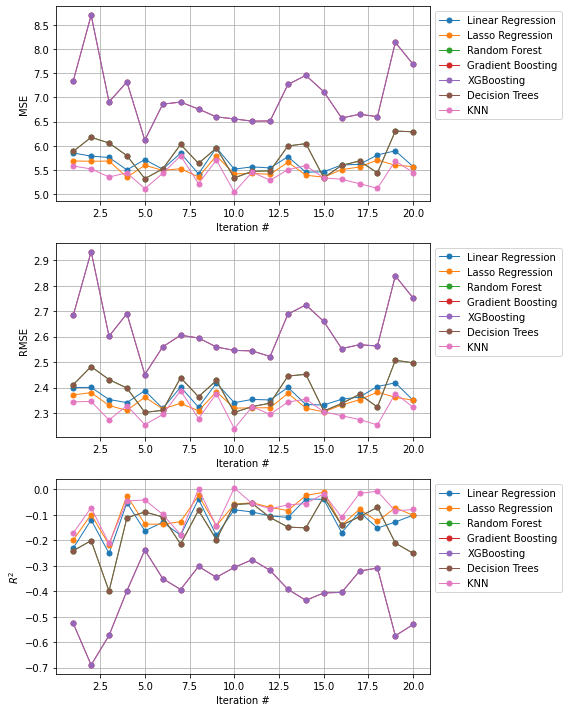

In [ ]:
fig,ax = plt.subplots(3,1,figsize = (8,10));

labels = ['Linear Regression', 'Lasso Regression', 'Gradient Boosting', 'Random Forest', 'XGBoosting', 'Decision Trees', 'KNN'];

iteration = range(1,21);
ax[0].plot(iteration,lr_mse, label= labels[0], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,Llr_mse, label= labels[1], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,RF_mse, label= labels[3], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,GB_mse,label= labels[2], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,XGB_mse,label= labels[4], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,DT_mse,label= labels[5], marker='o',linewidth=1, markersize=5)
ax[0].plot(iteration,KNN_mse,label= labels[6], marker='o',linewidth=1, markersize=5)
ax[0].set_ylabel("MSE")
ax[0].set_xlabel("Iteration #")
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].grid()

ax[1].plot(iteration,lr_rmse, label=labels[0],marker='o', linewidth=1, markersize=5)
ax[1].plot(iteration,Llr_rmse, label=labels[1],marker='o', linewidth=1, markersize=5)
ax[1].plot(iteration,RF_rmse, label=labels[3],marker='o', linewidth=1, markersize=5)
ax[1].plot(iteration,GB_rmse, label=labels[2],marker='o', linewidth=1, markersize=5)
ax[1].plot(iteration,XGB_rmse,label= labels[4], marker='o',linewidth=1, markersize=5)
ax[1].plot(iteration,DT_rmse,label= labels[5], marker='o',linewidth=1, markersize=5)
ax[1].plot(iteration,KNN_rmse,label= labels[6], marker='o',linewidth=1, markersize=5)
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Iteration #")
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].grid()

ax[2].plot(iteration,lr_r2,label=labels[0],marker='o', linewidth=1, markersize=5)
ax[2].plot(iteration,Llr_r2,label=labels[1],marker='o', linewidth=1, markersize=5)
ax[2].plot(iteration,RF_r2,label=labels[3],marker='o',linewidth=1, markersize=5)
ax[2].plot(iteration,GB_r2,label=labels[2],marker='o',linewidth=1, markersize=5)
ax[2].plot(iteration,XGB_r2,label= labels[4], marker='o',linewidth=1, markersize=5)
ax[2].plot(iteration,DT_r2,label= labels[5], marker='o',linewidth=1, markersize=5)
ax[2].plot(iteration,KNN_r2,label= labels[6], marker='o',linewidth=1, markersize=5)
ax[2].set_ylabel("$R^2$")
ax[2].set_xlabel("Iteration #")
ax[2].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[2].grid()


fname = picFolder + '/ModelError2.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')
plt.show()

Linear Regression p-val = 0.1006
Lasso Regression p-val = 1.0000
K-Nearest Neighbors p-val = 0.0008
Decision Trees p-val = 0.0000


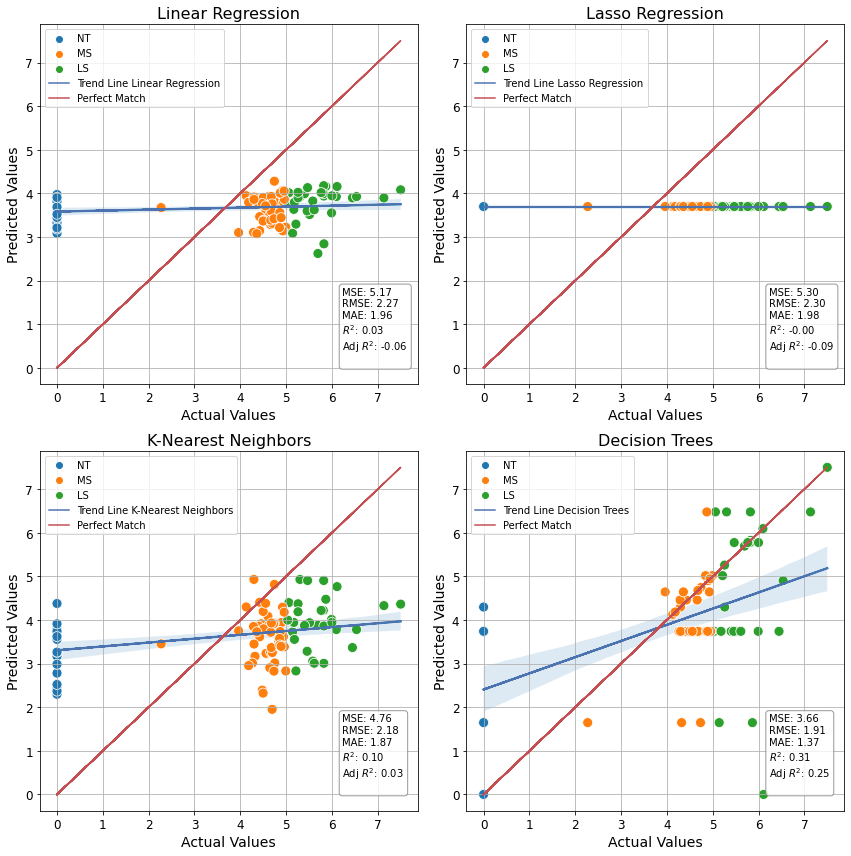

In [ ]:
# chosen iterations (the highest R2):
labels = ['Linear Regression', 'Lasso Regression', 'K-Nearest Neighbors', 'Decision Trees']
lr = LR[np.argmax(lr_r2)]
Llr = LLR[np.argmax(Llr_r2)]
knn = KNN[np.argmax(KNN_r2)]
dt = DT[np.argmax(DT_r2)]

model = [lr, Llr, knn, dt]
# predict prices with the models:
y_pred = [lr.predict(Xb), Llr.predict(Xb), knn.predict(Xb), dt.predict(Xb)]

pos = [[0,0], [0,1], [1,0], [1,1]];

# plot:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for ix in range(len(y_pred)):
    dummy = pd.DataFrame({'y': y, 'y_pred': y_pred[ix], 'Size': df2.Size, 'Week': df2.Week})
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred[ix])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred[ix])
    r2 = r2_score(y, y_pred[ix])
    adjusted_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - X.shape[1] - 1)
    mbd = np.mean(y_pred[ix] - y)
    
    # Calculate p-value
    slope, intercept, r_value, p_value, std_err = linregress(y, y_pred[ix])

    # Plot:
    h_ax = ax[pos[ix][0], pos[ix][1]]
    sns.regplot(data=dummy, x='y', y='y_pred', ax = h_ax, x_ci= 'ci', ci = 95)
    sns.scatterplot(data=dummy, x='y', y='y_pred', ax=h_ax, hue='Size', hue_order=sizeLabels, s=100)
    h_ax.set_xlabel('Actual Values', fontsize = 14)
    h_ax.set_ylabel('Predicted Values', fontsize = 14)
    
    coef = np.polyfit(y, y_pred[ix], 1)
    poly1d_fn = np.poly1d(coef)
    h_ax.plot(y, poly1d_fn(y), 'b-', label = f'Trend Line {labels[ix]}')
    h_ax.plot(y, y, 'r', label = 'Perfect Match')
    h_ax.legend(title = None, loc = 'upper left')
    
    # Add box annotation
    bbox_props = dict(boxstyle="round", fc="white", ec="gray", alpha=0.8)
    #textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \nMBD: {mbd:.2f} \n$R^2$: {r2:.2f} \nAdj $R^2$: {adjusted_r2:.2f} \np-value: {p_value:.3f}'
    textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \n$R^2$: {r2:.2f} \nAdj $R^2$: {adjusted_r2:.2f} \n'
    h_ax.text(0.8, 0.05, textstr, transform=h_ax.transAxes, fontsize=10,
                verticalalignment='bottom', bbox=bbox_props)
    h_ax.tick_params(axis='both', labelsize=12)

    h_ax.set_title(f'{labels[ix]}', fontsize = 16)
    h_ax.grid(True)
    
    print(f'{labels[ix]} p-val = {p_value:.4f}')

fname = picFolder + '/ModelOutput_FeatSel1.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')
plt.show()

Gradient Boosting p-val = 0.0000
XGBoosting p-val = 0.0000
Random Forest p-val = 0.0000


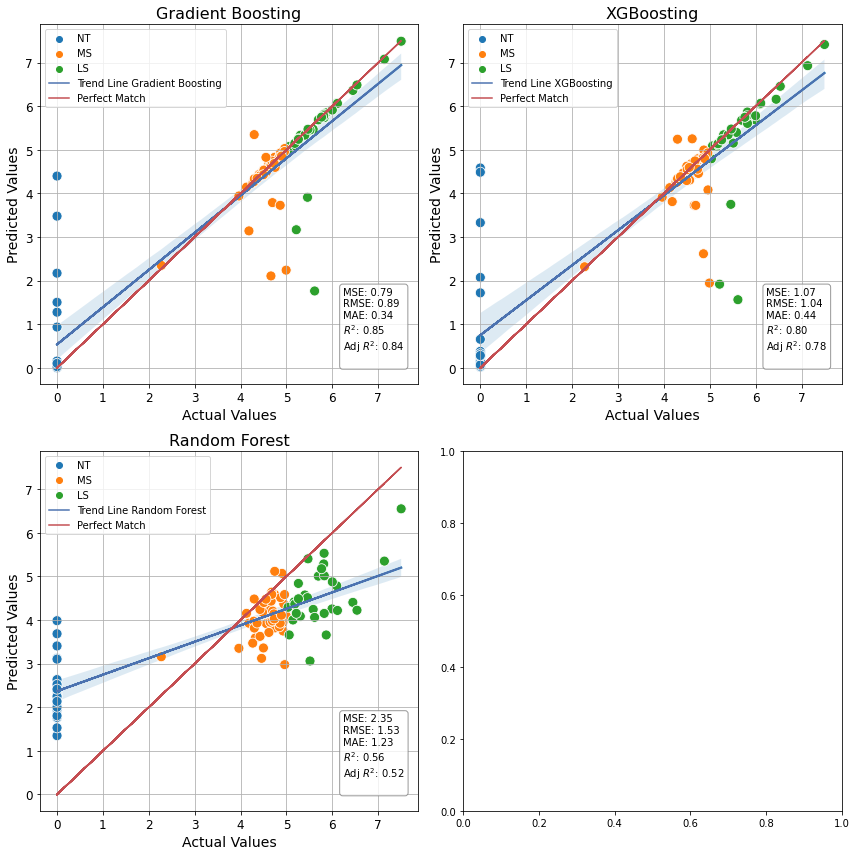

In [ ]:
# chosen iterations (the highest R2):
labels = ['Gradient Boosting', 'XGBoosting', 'Random Forest']
gb = GB[np.argmax(GB_r2)]
xgb = XGB[np.argmax(XGB_r2)]
rf = RF[np.argmax(RF_r2)]

model = [gb, xgb, rf]
# predict prices with the models:
y_pred = [gb.predict(Xb), xgb.predict(Xb), rf.predict(Xb)]

pos = [[0,0], [0,1], [1,0], [1,1]];

# plot:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for ix in range(len(y_pred)):
    dummy = pd.DataFrame({'y': y, 'y_pred': y_pred[ix], 'Size': df2.Size, 'Week': df2.Week})
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred[ix])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred[ix])
    r2 = r2_score(y, y_pred[ix])
    adjusted_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - X.shape[1] - 1)
    mbd = np.mean(y_pred[ix] - y)
    
    # Calculate p-value
    slope, intercept, r_value, p_value, std_err = linregress(y, y_pred[ix])

    # Plot:
    h_ax = ax[pos[ix][0], pos[ix][1]]
    sns.regplot(data=dummy, x='y', y='y_pred', ax = h_ax, x_ci= 'ci', ci = 95)
    sns.scatterplot(data=dummy, x='y', y='y_pred', ax=h_ax, hue='Size', hue_order=sizeLabels, s=100)
    h_ax.set_xlabel('Actual Values', fontsize = 14)
    h_ax.set_ylabel('Predicted Values', fontsize = 14)
    
    coef = np.polyfit(y, y_pred[ix], 1)
    poly1d_fn = np.poly1d(coef)
    h_ax.plot(y, poly1d_fn(y), 'b-', label = f'Trend Line {labels[ix]}')
    h_ax.plot(y, y, 'r', label = 'Perfect Match')
    h_ax.legend(title = None, loc = 'upper left')
    
    # Add box annotation
    bbox_props = dict(boxstyle="round", fc="white", ec="gray", alpha=0.8)
    #textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \nMBD: {mbd:.2f} \n$R^2$: {r2:.2f} \nAdj $R^2$: {adjusted_r2:.2f} \np-value: {p_value:.3f}'
    textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f} \nMAE: {mae:.2f} \n$R^2$: {r2:.2f} \nAdj $R^2$: {adjusted_r2:.2f} \n'
    h_ax.text(0.8, 0.05, textstr, transform=h_ax.transAxes, fontsize=10,
                verticalalignment='bottom', bbox=bbox_props)
    h_ax.tick_params(axis='both', labelsize=12)

    h_ax.set_title(f'{labels[ix]}', fontsize = 16)
    h_ax.grid(True)
    
    print(f'{labels[ix]} p-val = {p_value:.4f}')

fname = picFolder + '/ModelOutput_FeatSel2.png'    
plt.tight_layout()
plt.savefig(fname, dpi=200, format='png', metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')
plt.show()